# PART IV: ARIMA and SARIMA Models

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo

---

## 0. Setup

In [16]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PolyCollection, LineCollection

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20



def sm_plot(grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    plt.grid(grid, linestyle = ':', color = '0.50')
    # plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
    
    
def sm_plot_mod(ax, grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True,right = True, length = 5,width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8,width = 1, labelsize = 15)

---

In [3]:
df = pd.read_csv('../Data/data_reduced.csv', sep = ',')
df

,MESS_DATUM,WATER-LEVEL,DISCHARGE,RS,RS1,RS2,RS3,RS7,RS14,RSF,FLOOD,PIVOT
0,1990-01-01,4.548,22.0,0.1,0.102790,0.081214,0.000000,0.453204,6.117234,6.0,0,1
1,1990-01-03,4.548,22.0,0.0,0.000000,0.094785,0.079725,0.000000,2.474654,0.0,0,3
2,1990-01-04,4.548,22.0,0.0,0.082889,0.044273,0.000000,0.000000,0.000000,6.0,0,4
3,1990-01-06,3.799,20.0,0.0,0.000000,0.342618,2.186802,0.570589,0.720364,0.0,0,6
4,1990-01-07,3.799,20.0,0.0,1.056505,1.917828,0.787566,0.306570,0.848258,0.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
12057,2023-12-27,77.293,172.9,2.8,0.000000,13.805612,17.251582,27.545747,8.409038,4.0,0,12414
12058,2023-12-28,70.436,161.4,0.3,12.782493,0.592617,1.429676,12.063629,9.029170,4.0,0,12415
12059,2023-12-29,66.657,154.9,17.6,10.346342,0.000000,6.685611,0.813981,4.013248,4.0,0,12416
12060,2023-12-30,60.286,143.7,0.1,1.598052,5.983179,19.987744,5.539653,1.975216,4.0,0,12417


In [4]:
advanced_decomposition = STL(df['WATER-LEVEL'], period = 4).fit()
advanced_decomposition

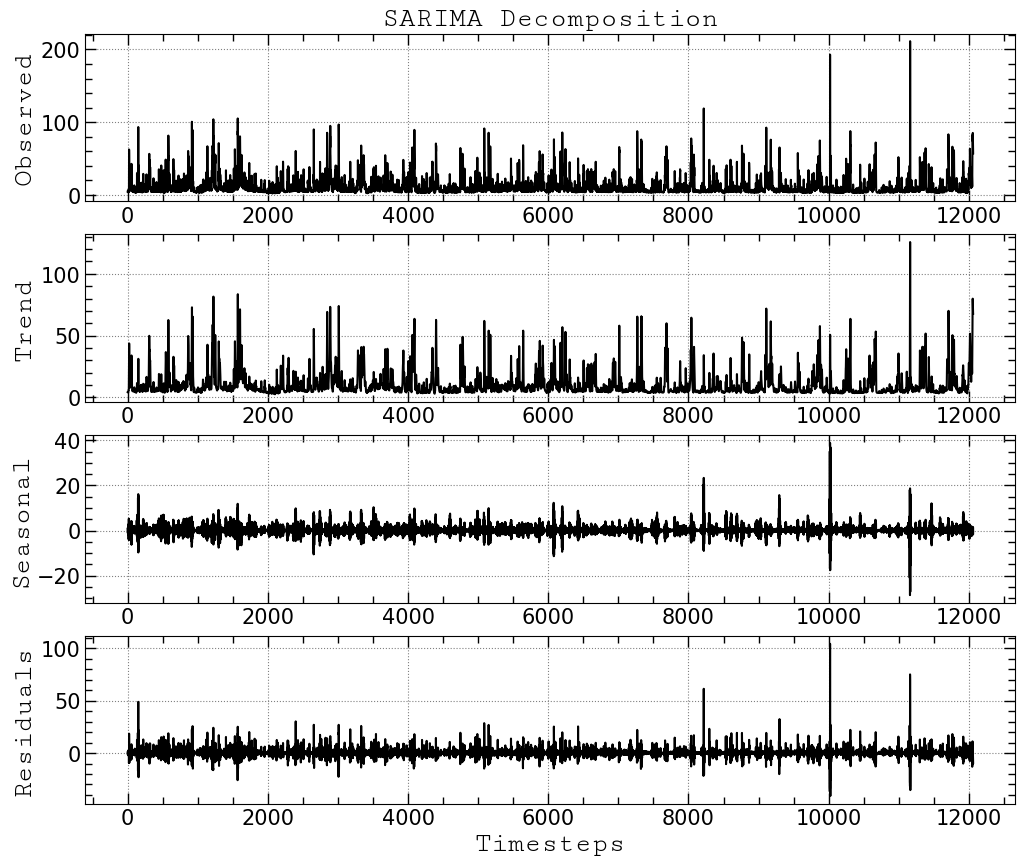

In [5]:
fig = plt.figure(figsize = (12, 10))
spec = gridspec.GridSpec(ncols = 1, nrows = 4, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])
ax2 = fig.add_subplot(spec[2, 0])
ax3 = fig.add_subplot(spec[3, 0])

ax0.plot(advanced_decomposition.observed, color = 'k')
ax1.plot(advanced_decomposition.trend, color = 'k')
ax2.plot(advanced_decomposition.seasonal, color = 'k')
ax3.plot(advanced_decomposition.resid, color = 'k')

ax0.set_title('SARIMA Decomposition', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('Observed', fontproperties = cm_font, fontsize = cm_size)
ax1.set_ylabel('Trend', fontproperties = cm_font, fontsize = cm_size)
ax2.set_ylabel('Seasonal', fontproperties = cm_font, fontsize = cm_size)
ax3.set_ylabel('Residuals', fontproperties = cm_font, fontsize = cm_size)
ax3.set_xlabel('Timesteps', fontproperties = cm_font, fontsize = cm_size)

sm_plot_mod(ax0)
sm_plot_mod(ax1)
sm_plot_mod(ax2)
sm_plot_mod(ax3)

In [6]:
def adfuller_test(y):
    adf_result = adfuller(y)

    print("ADF Statistic:", adf_result[0])
    print("P-Value:", adf_result[1])

adfuller_test(df['WATER-LEVEL'])

ADF Statistic: -15.382388805743165
P-Value: 3.3939653540348097e-28


In [7]:
n = len(df['WATER-LEVEL'])

# STURGES VALUE
nlags = 50
lags_sturges = int(np.log2(n) + 1)
acf_wl = acf(df['WATER-LEVEL'], nlags = nlags)
acf_dis = acf(df['DISCHARGE'], nlags = nlags)

In [8]:
def bartlett_confidence_intervals(acf_values, num_samples, confidence_level=0.95):
    z = 1.96  # Para um intervalo de confiança de 95%
    lags = np.arange(len(acf_values))
    # Inicializa a lista de desvios padrão
    standard_errors = np.zeros(len(acf_values))
    
    # Calcula o desvio padrão para cada lag usando a fórmula de Bartlett
    for k in lags:
        if k == 0:
            standard_errors[k] = 0  # ACF no lag 0 é 1, não há desvio padrão associado
        else:
            standard_errors[k] = np.sqrt((1 + 2 * np.sum(acf_values[:k] ** 2)) / num_samples)
    
    # Calcula o intervalo de confiança
    confidence_intervals = z * standard_errors
    
    return confidence_intervals


ci_wl = bartlett_confidence_intervals(acf_wl, n)
ci_dis = bartlett_confidence_intervals(acf_dis, n)

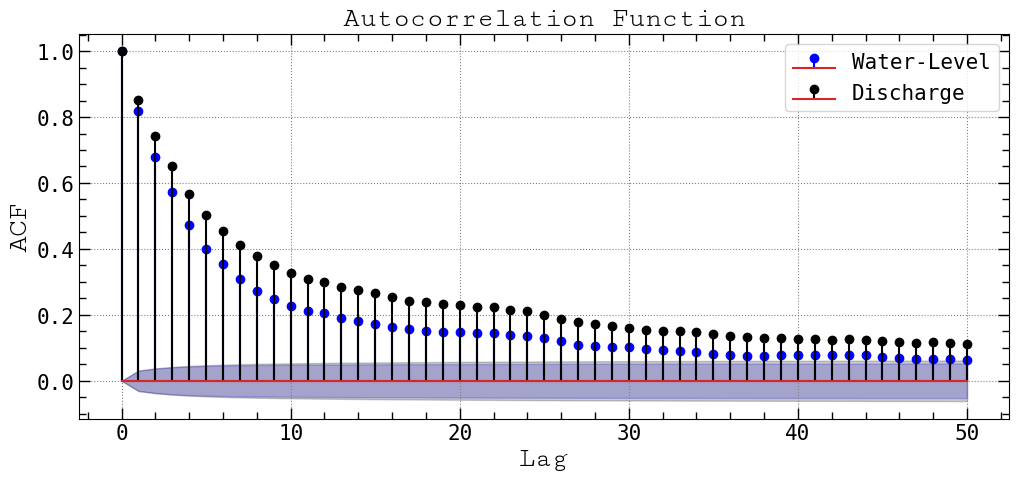

In [9]:
plt.figure(figsize = (12,5))

plt.stem(range(50 + 1), acf_wl, 'b', label = 'Water-Level')
plt.stem(range(50 + 1), acf_dis, 'k', label = 'Discharge')

lags = np.arange(51)
plt.fill_between(lags, ci_wl, -ci_wl, color = 'b', alpha = 0.2)
plt.fill_between(lags, ci_dis, -ci_dis, color = 'k', alpha = 0.2)

plt.title('Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
plt.xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)
plt.ylabel('ACF', fontproperties = cm_font, fontsize = cm_size)

sm_plot()
plt.legend(loc = 'best')

In [10]:
wl_diff = np.diff(df['WATER-LEVEL'], n = 2)
dis_diff = np.diff(df['DISCHARGE'], n = 2)

acf_wl_diff = acf(wl_diff, nlags = nlags)
acf_dis_diff = acf(dis_diff, nlags = nlags)

ci_wl_diff = bartlett_confidence_intervals(acf_wl_diff, n)
ci_dis_diff = bartlett_confidence_intervals(acf_dis_diff, n)

In [11]:
df_diff = np.diff(df['WATER-LEVEL'], n = 2)
adfuller_test(df_diff)

print("*"*50)

df_diff2 = np.diff(df_diff, n=1)
adfuller_test(df_diff2)

ADF Statistic: -34.26744685327699
P-Value: 0.0
**************************************************
ADF Statistic: -42.107070659255015
P-Value: 0.0


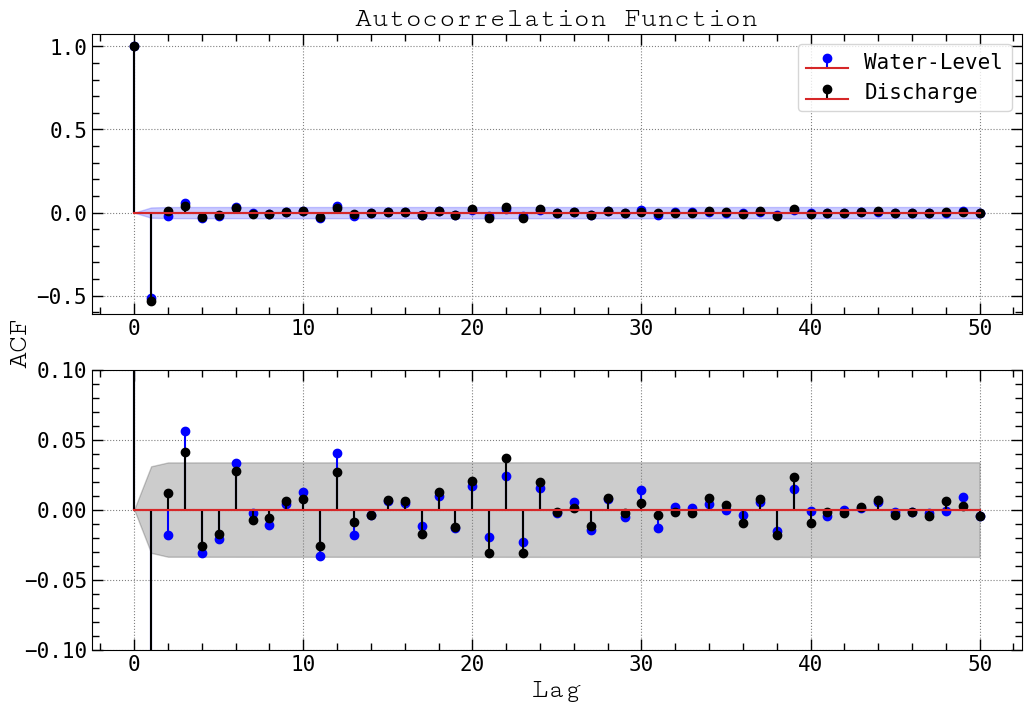

In [12]:
wl_diff = np.diff(df['WATER-LEVEL'], n = 2)
dis_diff = np.diff(df['DISCHARGE'], n = 2)

acf_wl_diff = acf(wl_diff, nlags = nlags)
acf_dis_diff = acf(dis_diff, nlags = nlags)

ci_wl_diff = bartlett_confidence_intervals(acf_wl_diff, n)
ci_dis_diff = bartlett_confidence_intervals(acf_dis_diff, n)




fig = plt.figure(figsize = (12,8))
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

ax0.stem(range(50 + 1), acf_wl_diff, 'b', label = 'Water-Level')
ax0.stem(range(50 + 1), acf_dis_diff, 'k', label = 'Discharge')

ax1.stem(range(50 + 1), acf_wl_diff, 'b', label = 'Water-Level')
ax1.stem(range(50 + 1), acf_dis_diff, 'k', label = 'Discharge')

ax0.fill_between(lags, ci_wl_diff, -ci_wl_diff, color = 'b', alpha = 0.2)
ax1.fill_between(lags, ci_dis_diff, -ci_dis_diff, color = 'k', alpha = 0.2)

ax0.set_title('Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
ax1.set_xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('ACF', y = -0.1, fontproperties = cm_font, fontsize = cm_size)

ax1.set_ylim(-0.1,0.1)

sm_plot_mod(ax0)
sm_plot_mod(ax1)
ax0.legend(loc = 'best')

In [13]:
df_diff = pd.DataFrame({'WATER-LEVEL': wl_diff})
df_diff

,WATER-LEVEL
0,0.000
1,-0.749
2,0.749
3,0.047
4,0.367
...,...
12055,-14.272
12056,1.046
12057,3.078
12058,-2.592


In [14]:
df_diff = pd.DataFrame({'WATER-LEVEL': wl_diff})

train_wl = df_diff[:1246]
test_wl = df_diff[1246:]

In [17]:
ARIMA_model = auto_arima(train_wl['WATER-LEVEL'], 
                      start_p = 2, 
                      start_q = 2,
                      test='adf', # use adftest to find optimal 'd'
                      tr = 50, max_q = 50, # maximum p and q
                      m = 1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d = 2,
                      seasonal = True, # No Seasonality for standard ARIMA
                      trace = True, #logs 
                      error_action = 'warn', #shows errors ('ignore' silences these)
                      suppress_warnings = True,
                      stepwise = True)
ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12568.307, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11576.781, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10928.406, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=10522.023, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=10332.715, Time=0.15 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=10138.859, Time=0.19 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=10140.858, Time=0.35 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 3.848 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1246
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -5063.429
Date:                Fri, 16 Aug 2024   AIC                          10138.859
Time:                        12:49:14   BIC                          10169.615
Sample:                             0   HQIC                         10150.424
                               - 1246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8983      0.012   -156.799      0.000      -1.922      -1.875
ar.L2         -2.1955      0.028    -79.206      0.000      -2.250      -2.141
ar.L3         -1.7943      0.037    -48.747      0.000      -1.866      -1.722
ar.L4         -1.0495      0.033    -31.529      0.000      -1.115      -0.984
ar.L5         -0.3826      0.017    -22.152      0.000      -0.416      -0.349
sigma2       200.1919      3.190     62.757      0.000     193.940     206.444
===================================================================================
Ljung-Box (L1) (Q):                  24.59   Jarque-Bera (JB):             42860.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -2.31
Prob(H) (two-sided):                  0.55   Kurtosis:                        31.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
ARIMA_model.plot_diagnostics?

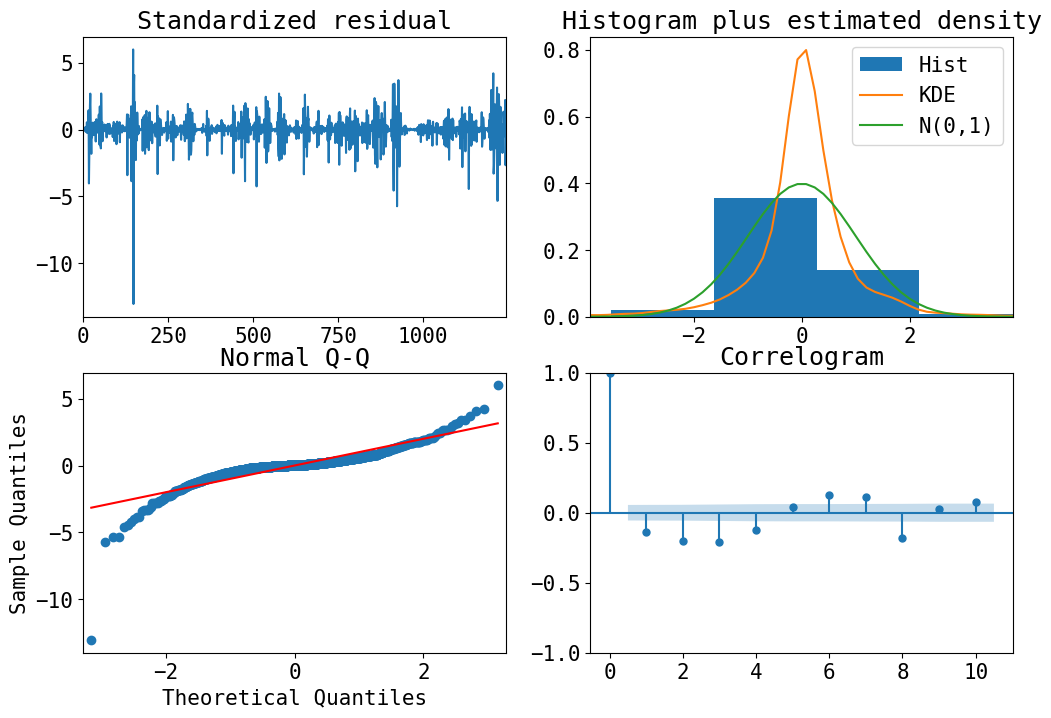

In [19]:
ARIMA_model.plot_diagnostics(figsize = (12,8))

plt.show()

In [6]:
ARIMA_model?

Object `ARIMA_model` not found.
